To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import PIL

In [2]:
data_dir_train = pathlib.Path("C:\\Users\\ritam\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train")
data_dir_test = pathlib.Path("C:\\Users\\ritam\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Test")

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [4]:
batch_size = 32
img_height = 180
img_width = 180

In [5]:
# ressizing images for training data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=32)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    subset='validation',
    image_size=(img_height, img_width),
    validation_split=0.2,
    shuffle=True,  # Assuming you want to shuffle the dataset
    batch_size=batch_size,  # Specify your batch size, assuming it's defined elsewhere
)


Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [7]:
# List of all the classes of skin cancer 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [8]:
# Function to convert the dataset to a NumPy array
def dataset_to_numpy(ds):
    images, labels = [], []
    for img_batch, label_batch in ds:
        images.append(img_batch.numpy())
        labels.append(label_batch.numpy())
    return np.concatenate(images, axis=0), np.concatenate(labels, axis=0)

## Data Visualization

In [9]:
examples_per_class = {class_name: None for class_name in class_names}

# Iterate over the dataset to find one example of each class
for images, labels in train_ds.unbatch().take(-1):  # Take all data but stop once we have all classes
    label = labels.numpy()
    class_name = class_names[label]
    if examples_per_class[class_name] is None:
        examples_per_class[class_name] = images.numpy()

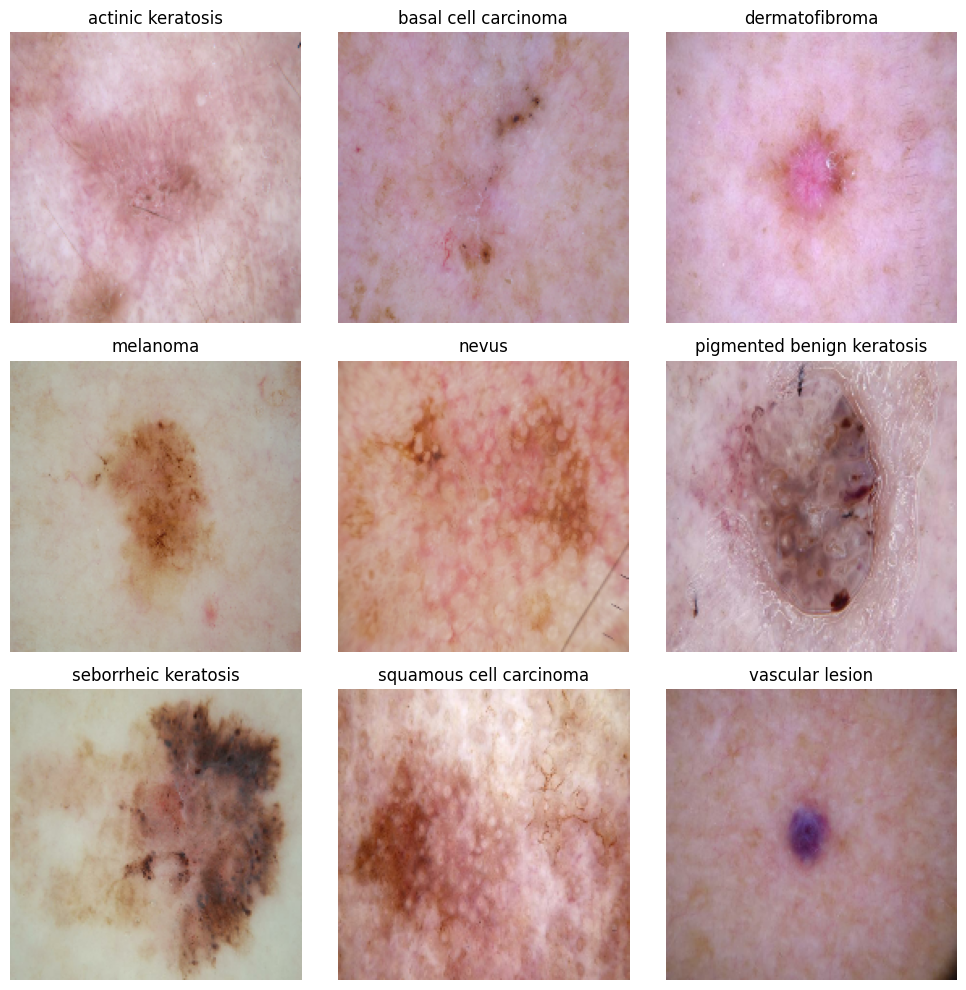

In [10]:
# Plotting
fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # Adjust the grid size according to the number of classes
axes = axes.flatten()

for i, class_name in enumerate(class_names):
    ax = axes[i]
    ax.imshow(examples_per_class[class_name].astype("uint8"))
    ax.set_title(class_name)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Creation


In [12]:
model = keras.Sequential([
    # Rescaling layer to normalize pixel values
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    # Convulational layer 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    
    # Convulational layer 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPool2D((2, 2)),
    
    # Convulational layer 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Flattening the output of the conv layers to feed into the dense layer
    layers.Flatten(),

    # Dense Layer
    layers.Dense(512, activation='relu'),
    layers.Dense(128, activation='relu'),

    # Output Layer
    layers.Dense(9, activation='softmax')
])
    

In [13]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

In [14]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 89, 89, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 44, 44, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 42, 42, 128)       7

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


169/169 [==============================] - 96s 537ms/step - loss: 1.8672 - accuracy: 0.2967 - val_loss: 1.5647 - val_accuracy: 0.4068
Epoch 2/20
169/169 [==============================] - 91s 541ms/step - loss: 1.5208 - accuracy: 0.4282 - val_loss: 1.3085 - val_accuracy: 0.5026
Epoch 3/20
169/169 [==============================] - 89s 525ms/step - loss: 1.2203 - accuracy: 0.5445 - val_loss: 1.0392 - val_accuracy: 0.6132
Epoch 4/20
169/169 [==============================] - 83s 490ms/step - loss: 0.9302 - accuracy: 0.6569 - val_loss: 1.0715 - val_accuracy: 0.6459
Epoch 5/20
169/169 [==============================] - 82s 483ms/step - loss: 0.6890 - accuracy: 0.7543 - val_loss: 0.8835 - val_accuracy: 0.6956
Epoch 6/20
169/169 [==============================] - 81s 480ms/step - loss: 0.5334 - accuracy: 0.8138 - val_loss: 0.8013 - val_accuracy: 0.7416
Epoch 7/20
169/169 [==============================] - 83s 490ms/step - loss: 0.3599 - accuracy: 0.8685 - val_loss: 0.7105 - val_

## Visualizing Training result

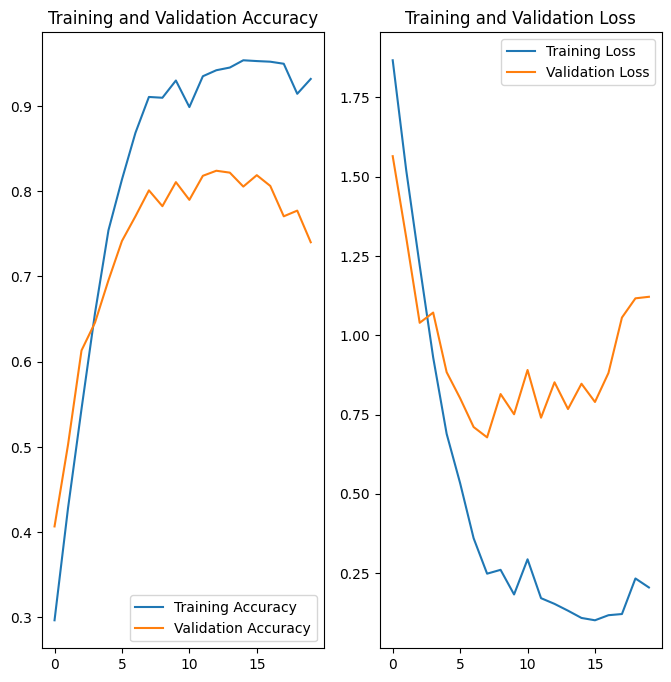

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


The model is clearly overfitting as evident from the difference in training and validation accuracy scores as well as the losses. Let's add a dropout layer after each maxpooling layer to try coping up with the problem.

### Adding Dropout Layer

In [17]:
model_with_dropout = keras.Sequential([
    # Rescaling layer to normalize pixel values
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    # Convulational layer 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.25),
    
    # Convulational layer 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.25),
    
    # Convulational layer 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    # Flattening the output of the conv layers to feed into the dense layer
    layers.Flatten(),

    # Dense Layer
    layers.Dense(512, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    # Output Layer
    layers.Dense(9, activation='softmax')
])
    

### Compiling the model

In [18]:
model_with_dropout.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

### Training the Model

In [19]:
history = model_with_dropout.fit(
                                  train_ds,
                                  validation_data=val_ds,
                                  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 88s 513ms/step - loss: 2.2452 - accuracy: 0.1424 - val_loss: 2.1871 - val_accuracy: 0.1418
Epoch 2/20
169/169 [==============================] - 87s 513ms/step - loss: 2.1211 - accuracy: 0.1786 - val_loss: 2.0265 - val_accuracy: 0.2361
Epoch 3/20
169/169 [==============================] - 89s 524ms/step - loss: 1.8352 - accuracy: 0.3055 - val_loss: 1.5834 - val_accuracy: 0.3883
Epoch 4/20
169/169 [==============================] - 87s 517ms/step - loss: 1.4713 - accuracy: 0.4266 - val_loss: 1.3544 - val_accuracy: 0.4944
Epoch 5/20
169/169 [==============================] - 87s 516ms/step - loss: 1.3233 - accuracy: 0.5004 - val_loss: 1.1990 - val_accuracy: 0.5568
Epoch 6/20
169/169 [==============================] - 88s 521ms/step - loss: 1.0932 - accuracy: 0.5831 - val_loss: 1.0021 - val_accuracy: 0.6377
Epoch 7/20
169/169 [==============================] - 88s 520ms/step - loss: 0.8595 - accuracy: 0.6801 - val_loss: 0.9059 - val_ac

## Visualizing Training result

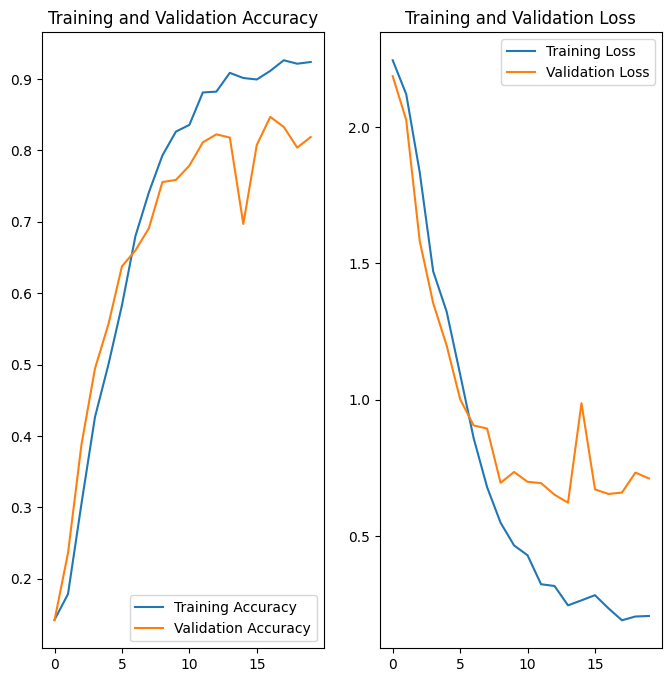

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


The overfitting has decreased a little, but the validation accuracy is still significantly less than that of Training accuracy. Next, let's use the Augmentor Class to create synthetic data.

### Using Augmentor to create synthetic images

In [21]:
path_to_training_dataset='C:\\Users\\ritam\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to C:\Users\ritam\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1CE2DDA1310>: 100%|█| 500/500 [00:01<00:


Initialised with 376 image(s) found.
Output directory set to C:\Users\ritam\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1CE2DE44510>: 100%|█| 500/500 [00:01<00:


Initialised with 95 image(s) found.
Output directory set to C:\Users\ritam\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1CE2569F690>: 100%|█| 500/500 [00:01<00:


Initialised with 438 image(s) found.
Output directory set to C:\Users\ritam\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1CE2DE58390>: 100%|█| 500/500 [00:07<00:00, 67.64 Samples


Initialised with 357 image(s) found.
Output directory set to C:\Users\ritam\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x1CE2DE39E90>: 100%|█| 500/500 [00:06<00:


Initialised with 462 image(s) found.
Output directory set to C:\Users\ritam\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CE255D26D0>: 100%|█| 500/500 [00:01<00:00, 367.56 Samples


Initialised with 77 image(s) found.
Output directory set to C:\Users\ritam\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1CE24DD2E10>: 100%|█| 500/500 [00:03<00:00, 151.75 Sample


Initialised with 181 image(s) found.
Output directory set to C:\Users\ritam\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CE254A7310>: 100%|█| 500/500 [00:01<00:00, 345.35 Samples


Initialised with 139 image(s) found.
Output directory set to C:\Users\ritam\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1CE24EC9A10>: 100%|█| 500/500 [00:01<00:00, 321.01 Samples


In [22]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)     

9000


In [23]:
train_ds_new = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=32)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [24]:
val_ds_new = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    subset='validation',
    image_size=(img_height, img_width),
    validation_split=0.2,
    shuffle=True,  # Assuming you want to shuffle the dataset
    batch_size=batch_size,  # Specify your batch size, assuming it's defined elsewhere
)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [25]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds_new = train_ds_new.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_new = val_ds_new.cache().prefetch(buffer_size=AUTOTUNE)

### Fitting the model without dropout to check the overfitting issue

In [26]:
epochs = 20
history = model.fit(
  train_ds_new,
  validation_data=val_ds_new,
  epochs=epochs)

Epoch 1/20
281/281 [==============================] - 146s 496ms/step - loss: 0.3456 - accuracy: 0.8918 - val_loss: 0.2670 - val_accuracy: 0.9021
Epoch 2/20
281/281 [==============================] - 139s 494ms/step - loss: 0.1481 - accuracy: 0.9440 - val_loss: 0.2757 - val_accuracy: 0.9016
Epoch 3/20
281/281 [==============================] - 135s 480ms/step - loss: 0.1491 - accuracy: 0.9404 - val_loss: 0.2688 - val_accuracy: 0.9150
Epoch 4/20
281/281 [==============================] - 135s 482ms/step - loss: 0.1319 - accuracy: 0.9453 - val_loss: 0.2345 - val_accuracy: 0.9217
Epoch 5/20
281/281 [==============================] - 139s 493ms/step - loss: 0.1057 - accuracy: 0.9534 - val_loss: 0.2452 - val_accuracy: 0.9235
Epoch 6/20
281/281 [==============================] - 136s 483ms/step - loss: 0.0933 - accuracy: 0.9567 - val_loss: 0.2566 - val_accuracy: 0.9181
Epoch 7/20
281/281 [==============================] - 135s 480ms/step - loss: 0.0958 - accuracy: 0.9582 - val_loss: 0.3165 -

## Visualizing Training result

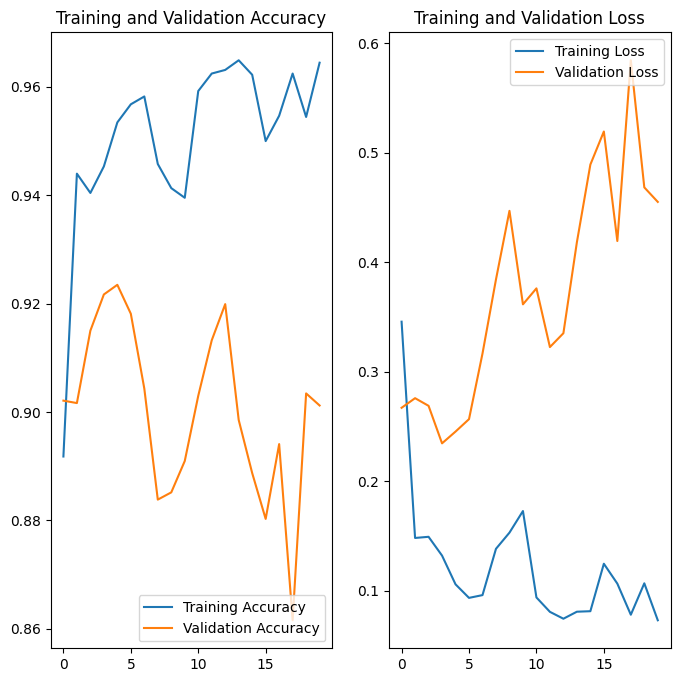

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

There has been considerable increase in the validation accuracy after handling class imbalance. There is still a little space of improvement. So, let's use the model with dropout on the new training data

### Training the Model

In [29]:
epochs = 30
history = model_with_dropout.fit(
  train_ds_new,
  validation_data=val_ds_new,
  epochs=epochs)

Epoch 1/30
281/281 [==============================] - 142s 506ms/step - loss: 0.2309 - accuracy: 0.9147 - val_loss: 0.2599 - val_accuracy: 0.9119
Epoch 2/30
281/281 [==============================] - 143s 509ms/step - loss: 0.1807 - accuracy: 0.9310 - val_loss: 0.2138 - val_accuracy: 0.9279
Epoch 3/30
281/281 [==============================] - 142s 506ms/step - loss: 0.1903 - accuracy: 0.9304 - val_loss: 0.2087 - val_accuracy: 0.9266
Epoch 4/30
281/281 [==============================] - 142s 507ms/step - loss: 0.1639 - accuracy: 0.9364 - val_loss: 0.2652 - val_accuracy: 0.9137
Epoch 5/30
281/281 [==============================] - 149s 529ms/step - loss: 0.2146 - accuracy: 0.9215 - val_loss: 0.3195 - val_accuracy: 0.8954
Epoch 6/30
281/281 [==============================] - 144s 514ms/step - loss: 0.1590 - accuracy: 0.9378 - val_loss: 0.2408 - val_accuracy: 0.9177
Epoch 7/30
281/281 [==============================] - 143s 509ms/step - loss: 0.1547 - accuracy: 0.9407 - val_loss: 0.2377 -

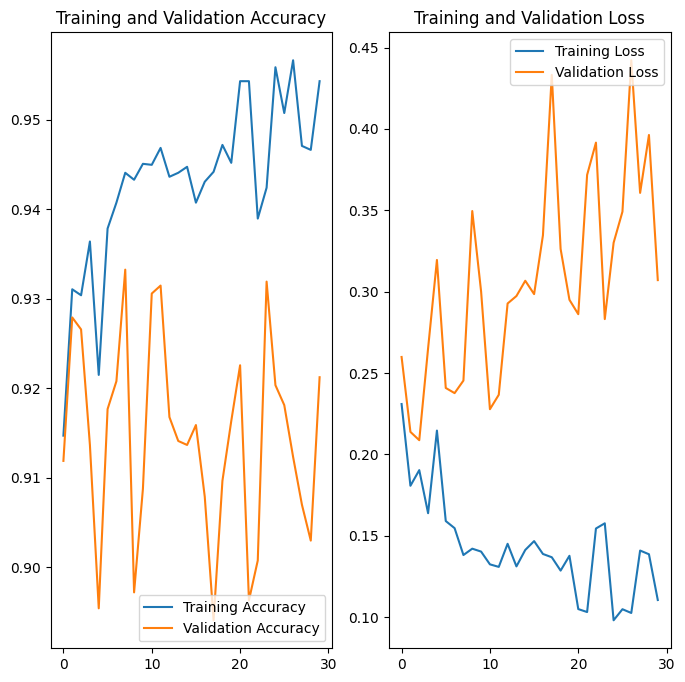

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The overfitting has been handled now to a great extent. There is still a little difference, but that's managable. 